# Upload Fine-tuned ViT Model to Hugging Face

This notebook uploads your fine-tuned Vision Transformer model to the Hugging Face Hub using the reliable file-by-file upload method.


## 1. Install Required Packages


In [1]:
%pip install huggingface_hub
%pip install transformers


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 2. Login to Hugging Face

Get your token from: https://huggingface.co/settings/tokens (create one with write permissions)


In [13]:
from huggingface_hub import login
from token_identification import HUGGINGFACE_TOKEN

# Login using token from tokens.py
login(token=HUGGINGFACE_TOKEN)

print("✅ Logged in successfully!")


✅ Logged in successfully!


## 3. Create Model Card (README)

This creates a comprehensive model card with your model's details and metrics.


In [3]:
model_card_content = """---
language: sr
license: apache-2.0
tags:
- image-classification
- vision
- vit
- house-condition
datasets:
- custom
metrics:
- accuracy
---

# Fine-tuned ViT for House Condition Classification

This model is a fine-tuned version of [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) for classifying house conditions into 4 categories.

## Model Description

This Vision Transformer (ViT) model has been fine-tuned to classify house images into four condition categories:
- **dobre** (good condition)
- **nepoznato** (unknown condition)
- **oronule** (dilapidated condition)
- **srednje** (medium condition)

## Training Details

### Training Data
- Training set: 757 images
- Validation set: 80 images
- Test set: 79 images

### Training Hyperparameters
- Epochs: 10
- Batch size: 16
- Learning rate: 2e-5
- Optimizer: AdamW
- Seed: 42 (for reproducibility)

## Evaluation Results

### Validation Set Performance
- **Accuracy**: 80.0%
- **Loss**: 0.7827

### Per-Class Metrics (Validation)
| Class      | Precision | Recall | F1-Score | Support |
|------------|-----------|--------|----------|----------|
| dobre      | 0.83      | 0.50   | 0.62     | 10       |
| nepoznato  | 1.00      | 0.83   | 0.91     | 24       |
| oronule    | 0.71      | 0.80   | 0.75     | 15       |
| srednje    | 0.73      | 0.87   | 0.79     | 31       |

### Confusion Matrix (Validation)
```
[[ 5  0  0  5]    # dobre
 [ 1 20  1  2]    # nepoznato
 [ 0  0 12  3]    # oronule
 [ 0  0  4 27]]   # srednje
```

## Usage

```python
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch

# Load model and processor
model = ViTForImageClassification.from_pretrained("YOUR_USERNAME/YOUR_MODEL_NAME")
processor = ViTImageProcessor.from_pretrained("YOUR_USERNAME/YOUR_MODEL_NAME")

# Load and preprocess image
image = Image.open("path_to_image.jpg").convert("RGB")
inputs = processor(image, return_tensors="pt")

# Make prediction
with torch.no_grad():
    outputs = model(**inputs)
    
predicted_class_idx = outputs.logits.argmax(-1).item()
predicted_label = model.config.id2label[str(predicted_class_idx)]

print(f"Predicted class: {predicted_label}")

# Get probabilities
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
for idx, prob in enumerate(probs):
    label = model.config.id2label[str(idx)]
    print(f"{label}: {prob.item():.2%}")
```

## Limitations and Bias

- The model was trained on a specific dataset of house images and may not generalize well to different architectural styles or regions
- Performance varies by class, with lower recall for the "dobre" (good condition) class
- The model may have difficulty distinguishing between similar condition categories
- Training set is relatively small (757 images)

## Training Procedure

The model was fine-tuned using the Hugging Face Transformers library with the following approach:
1. Pre-trained weights from google/vit-base-patch16-224-in21k were used as initialization
2. The classification head was replaced with a new 4-class classifier
3. All model parameters were fine-tuned on the custom dataset
4. Early stopping and checkpoint saving were employed to prevent overfitting
5. Images were converted to RGB to ensure consistent 3-channel input

## Citation

If you use this model, please cite:

```bibtex
@misc{house-condition-vit,
  author = {Your Name},
  title = {Fine-tuned ViT for House Condition Classification},
  year = {2025},
  publisher = {Hugging Face},
  howpublished = {\\url{https://huggingface.co/YOUR_USERNAME/YOUR_MODEL_NAME}}
}
```

## Model Card Authors

This model card was created by the model author.
"""

# Save model card to file
import os
os.makedirs("./vit-results", exist_ok=True)
with open("./vit-results/README.md", "w", encoding="utf-8") as f:
    f.write(model_card_content)

print("✅ Model card created successfully at: ./vit-results/README.md")


✅ Model card created successfully at: ./vit-results/README.md


## 4. Upload Model to Hugging Face Hub

This uses the reliable file-by-file upload method.


In [5]:
from huggingface_hub import HfApi, create_repo, upload_file
import os

# CHANGE THIS: Set your repository name
repo_id = "DejanX13/vit-house-classifier"  # e.g., "dejan/vit-house-classifier"

# Path to your trained model directory
model_path = "./vit-results"

print(f"📦 Preparing to upload model from: {model_path}")
print(f"🎯 Target repository: {repo_id}\n")

# Step 1: Create the repository
try:
    create_repo(repo_id=repo_id, repo_type="model", exist_ok=True)
    print(f"✅ Repository '{repo_id}' created/confirmed successfully.\n")
except Exception as e:
    print(f"❌ Error creating repository: {e}")
    raise

# Step 2: Initialize API
api = HfApi()

# Step 3: Define files to upload
essential_files = [
    "config.json",              # Model configuration
    "model.safetensors",        # Model weights
    "preprocessor_config.json", # Preprocessor configuration
    "README.md",                # Model card
]

optional_files = [
    "train_results.json",       # Training metrics
    "eval_results.json",        # Evaluation metrics
    "all_results.json",         # Combined results
    "trainer_state.json",       # Trainer state
    "training_args.bin",        # Training arguments
]

# Step 4: Upload essential files
print("📤 Uploading essential model files...")
uploaded_count = 0
for file_name in essential_files:
    file_path = os.path.join(model_path, file_name)
    if os.path.exists(file_path):
        try:
            api.upload_file(
                path_or_fileobj=file_path,
                path_in_repo=file_name,
                repo_id=repo_id,
                repo_type="model",
            )
            print(f"  ✓ {file_name}")
            uploaded_count += 1
        except Exception as e:
            print(f"  ✗ Failed: {file_name} - {e}")
    else:
        print(f"  ⚠ Not found: {file_name}")

# Step 5: Upload optional files
print("\n📤 Uploading optional result files...")
for file_name in optional_files:
    file_path = os.path.join(model_path, file_name)
    if os.path.exists(file_path):
        try:
            api.upload_file(
                path_or_fileobj=file_path,
                path_in_repo=file_name,
                repo_id=repo_id,
                repo_type="model",
            )
            print(f"  ✓ {file_name}")
            uploaded_count += 1
        except Exception as e:
            print(f"  ⚠ Skipped: {file_name}")

print(f"\n✅ Upload complete! {uploaded_count} files uploaded.")
print(f"\n🌐 View your model at: https://huggingface.co/{repo_id}")


📦 Preparing to upload model from: ./vit-results
🎯 Target repository: DejanX13/vit-house-classifier

✅ Repository 'DejanX13/vit-house-classifier' created/confirmed successfully.

📤 Uploading essential model files...
  ✓ config.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

  ✓ model.safetensors
  ✓ preprocessor_config.json
  ✓ README.md

📤 Uploading optional result files...
  ✓ train_results.json
  ✓ eval_results.json
  ✓ all_results.json
  ✓ trainer_state.json


Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

  ✓ training_args.bin

✅ Upload complete! 9 files uploaded.

🌐 View your model at: https://huggingface.co/DejanX13/vit-house-classifier


## 5. Verify Upload (Optional)

Test that your model can be loaded from the Hub.


In [6]:
from transformers import ViTForImageClassification, ViTImageProcessor

# Load model from Hub to verify it works
print("🔄 Loading model from Hugging Face Hub...")
try:
    test_model = ViTForImageClassification.from_pretrained(repo_id)
    test_processor = ViTImageProcessor.from_pretrained(repo_id)
    
    print("✅ Model loaded successfully from Hub!\n")
    print(f"Model has {test_model.config.num_labels} labels:")
    for idx, label in test_model.config.id2label.items():
        print(f"  {idx}: {label}")
    
    print(f"\n📚 Share your model:")
    print(f'   from transformers import ViTForImageClassification, ViTImageProcessor')
    print(f'   model = ViTForImageClassification.from_pretrained("{repo_id}")')
    print(f'   processor = ViTImageProcessor.from_pretrained("{repo_id}")')
    
except Exception as e:
    print(f"❌ Error loading model: {e}")


🔄 Loading model from Hugging Face Hub...


config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

✅ Model loaded successfully from Hub!

Model has 4 labels:
  0: dobre
  1: nepoznato
  2: oronule
  3: srednje

📚 Share your model:
   from transformers import ViTForImageClassification, ViTImageProcessor
   model = ViTForImageClassification.from_pretrained("DejanX13/vit-house-classifier")
   processor = ViTImageProcessor.from_pretrained("DejanX13/vit-house-classifier")


## 6. Test with a Sample Image (Optional)

Test your uploaded model with an actual image.


📸 Testing with image: slike_kuce_bgns/test/dobre/kuca_14392.jpg
   Image size: (600, 400)

🎯 Prediction: srednje

📊 Probabilities:
  dobre         5.39% ██
  nepoznato     7.73% ███
  oronule      24.31% ████████████
  srednje      62.57% ███████████████████████████████


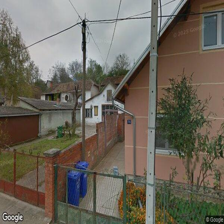

In [9]:
from PIL import Image
import torch

# Uncomment and set path to test with an actual image
test_image_path = "slike_kuce_bgns/test/dobre/kuca_14392.jpg"  # Change this path

try:
    # Load image
    image = Image.open(test_image_path).convert("RGB")
    print(f"📸 Testing with image: {test_image_path}")
    print(f"   Image size: {image.size}")
    
    # Preprocess
    inputs = test_processor(image, return_tensors="pt")
    
    # Predict
    with torch.no_grad():
        outputs = test_model(**inputs)
    
    # Get prediction
    predicted_idx = outputs.logits.argmax(-1).item()
    
    # Handle both string and integer keys in id2label
    id2label = test_model.config.id2label
    if str(predicted_idx) in id2label:
        predicted_label = id2label[str(predicted_idx)]
    elif predicted_idx in id2label:
        predicted_label = id2label[predicted_idx]
    else:
        predicted_label = f"Unknown (class {predicted_idx})"
    
    # Get probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0]
    
    print(f"\n🎯 Prediction: {predicted_label}\n")
    print("📊 Probabilities:")
    for idx in range(len(probs)):
        # Handle both string and integer keys
        if str(idx) in id2label:
            label = id2label[str(idx)]
        elif idx in id2label:
            label = id2label[idx]
        else:
            label = f"Class {idx}"
        prob = probs[idx].item()
        bar = "█" * int(prob * 50)
        print(f"  {label:12s} {prob:6.2%} {bar}")
    
    # Display image (in Jupyter)
    display(image.resize((224, 224)))
    
except FileNotFoundError:
    print(f"⚠ Image not found: {test_image_path}")
    print("   Change the test_image_path variable to a valid image path.")
except Exception as e:
    print(f"❌ Error during prediction: {e}")
    import traceback
    traceback.print_exc()


# Upload Fine-tuned ViT Model to Hugging Face

This notebook uploads your fine-tuned Vision Transformer model to the Hugging Face Hub.
